<a href="https://colab.research.google.com/github/K-Erath/Dataquest/blob/master/15_Predicting_Car_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Car Prices
For this project we will try to find the best model for predicting car prices using a machine learning algorithim known as K-Nearest Neighbors. K-Nearest Neighbors computes Euclidean Distance to find similarity and average to predict an unseen value.

We wil use a dataset that contains information on various cars. For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. You can read more about the data set [here](https://archive.ics.uci.edu/ml/datasets/automobile) and can download it directly from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data).

To find the best model, we will
1. Select relevant features to use for predicting the target column.
2. Use grid search to find the optimal hyperparameter value for the selected features.
3. Evaluate the model's accuracy and repeat the process.

We will start by using a machine learning algorithm, k-nearest neighbors, to predict car prices.


TODO:
Lookinto using pearsons correlation like [this](https://community.dataquest.io/t/guided-project-predicting-us-car-import-car-prices-feedback-welcomed/559839) Then drop columns that are highly correlated from the final chosen features.

Why does the solution divide test and training 50-50.

## Introduction To The Data Set

In [ ]:
import pandas as pd

In [ ]:
csv = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data" 
cars = pd.read_csv(csv)
cars.head()

,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,168.80,64.10,48.80,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


The column names are missing and that is messing up the table. Let's read the column names from the [documentation](https://archive.ics.uci.edu/ml/datasets/automobile).

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
url = "https://archive.ics.uci.edu/ml/datasets/automobile"
resp = requests.get(url)

In [ ]:
from urllib.request import urlopen

html = urlopen(url).read()
soup = BeautifulSoup(html, features="html.parser")
text = soup.body.get_text()

In [ ]:
# break into lines and remove leading and trailing space on each
lines = (line.strip() for line in text.splitlines())
# break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))

In [ ]:
import re
# pattern captures string that starts with one or more digit, a period, and then a space
pat = re.compile(r"^\d+\.\s")

column_names = []

for chunk in chunks:
    # if the line matches the pattern
    if pat.search(chunk) != None:
        # get the text after the pattern and remove the colon
        column_name = re.split(pat, chunk)[1].replace(':', '')
        # append text to list of columns names
        column_names.append(column_name)

column_names

['symboling',
 'normalized-losses',
 'make',
 'fuel-type',
 'aspiration',
 'num-of-doors',
 'body-style',
 'drive-wheels',
 'engine-location',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'engine-type',
 'num-of-cylinders',
 'engine-size',
 'fuel-system',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg',
 'price']

Read data again but this time pass in column names.

In [ ]:
pd.set_option("display.max_columns", 30)

In [ ]:
cars = pd.read_csv(csv, names=column_names)
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

## Data Cleaning

We usually can't have any missing values if we want to use them for predictive modeling. In particular, K-Nearest Neighbors uses Euclidean distance and there are a few things that do not work well for Euclidean Distance:
* Non-numerical values
* Missing values
* Non-ordinal values (i.e. latitude, longitude - can’t rank)

Based on the data set preview from the last step, we can tell that the normalized-losses column contains missing values represented using "?". Let's replace these values and look for the presence of missing values in other numeric columns. Let's also rescale the values in the numeric columns so they all range from 0 to 1.

In [ ]:
import numpy as np

In [ ]:
# replace ? with null
cars.replace('?', np.nan, inplace=True)

In [ ]:
# only numeric columns will be useful for our analysis
numeric_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars_numeric = cars[numeric_cols]
cars_numeric.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,NaN,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


In [ ]:
cars_numeric = cars_numeric.astype('float64')
cars_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  164 non-null    float64
 1   wheel-base         205 non-null    float64
 2   length             205 non-null    float64
 3   width              205 non-null    float64
 4   height             205 non-null    float64
 5   curb-weight        205 non-null    float64
 6   engine-size        205 non-null    float64
 7   bore               201 non-null    float64
 8   stroke             201 non-null    float64
 9   compression-ratio  205 non-null    float64
 10  horsepower         203 non-null    float64
 11  peak-rpm           203 non-null    float64
 12  city-mpg           205 non-null    float64
 13  highway-mpg        205 non-null    float64
 14  price              201 non-null    float64
dtypes: float64(15)
memory usage: 24.1 KB


Since price is our target, we will drop any rows that have null price.

In [ ]:
cars_clean = cars_numeric.dropna(axis=0, subset=['price']).copy()
cars_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  164 non-null    float64
 1   wheel-base         201 non-null    float64
 2   length             201 non-null    float64
 3   width              201 non-null    float64
 4   height             201 non-null    float64
 5   curb-weight        201 non-null    float64
 6   engine-size        201 non-null    float64
 7   bore               197 non-null    float64
 8   stroke             197 non-null    float64
 9   compression-ratio  201 non-null    float64
 10  horsepower         199 non-null    float64
 11  peak-rpm           199 non-null    float64
 12  city-mpg           201 non-null    float64
 13  highway-mpg        201 non-null    float64
 14  price              201 non-null    float64
dtypes: float64(15)
memory usage: 25.1 KB


For columns that are only missing a few values, we will replace nulls with the mean for that column. The normalized losses column is missing about 20% of values, so we will drop that column.

In [ ]:
cars_clean.fillna(cars_clean.mean(), inplace=True)
cars_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  201 non-null    float64
 1   wheel-base         201 non-null    float64
 2   length             201 non-null    float64
 3   width              201 non-null    float64
 4   height             201 non-null    float64
 5   curb-weight        201 non-null    float64
 6   engine-size        201 non-null    float64
 7   bore               201 non-null    float64
 8   stroke             201 non-null    float64
 9   compression-ratio  201 non-null    float64
 10  horsepower         201 non-null    float64
 11  peak-rpm           201 non-null    float64
 12  city-mpg           201 non-null    float64
 13  highway-mpg        201 non-null    float64
 14  price              201 non-null    float64
dtypes: float64(15)
memory usage: 25.1 KB


In [ ]:
cars_clean = cars_clean.drop('normalized-losses', axis=1)
cars_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wheel-base         201 non-null    float64
 1   length             201 non-null    float64
 2   width              201 non-null    float64
 3   height             201 non-null    float64
 4   curb-weight        201 non-null    float64
 5   engine-size        201 non-null    float64
 6   bore               201 non-null    float64
 7   stroke             201 non-null    float64
 8   compression-ratio  201 non-null    float64
 9   horsepower         201 non-null    float64
 10  peak-rpm           201 non-null    float64
 11  city-mpg           201 non-null    float64
 12  highway-mpg        201 non-null    float64
 13  price              201 non-null    float64
dtypes: float64(14)
memory usage: 23.6 KB


Normalize all columnns to range from 0 to 1 except the target column. This is refered to as [Min-Max Scaling](https://rstatisticsblog.com/data-science-in-action/data-preprocessing/z-score-standardization-or-min-max-scaling/) or [Linear Normalization](https://analystanswers.com/data-normalization-techniques-easy-to-advanced-the-best/).

In [ ]:
# save the values in the price column
price_col = cars_clean['price']
# Subtract each value in the column by the min value for that column & divide by the difference between the max and the mean
cars_clean = (cars_clean - cars_clean.min())/(cars_clean.max() - cars_clean.min())
# assign the original values back to the price column
cars_clean['price'] = price_col
cars_clean.head()

,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


## Univariate Model
We will start with a univariate (single feature) model because starting with simple models before moving to more complex models helps us structure our code workflow and understand the features better.

We will randomize the order of the rows in the dataset. This is important because if the dataset were sorted by height, and we select the first 5 cars, we would be biasing the result to the ordering of the dataset.

Whenever you're performing machine learning, you want to perform validation of some kind to ensure that your machine learning model can make good predictions on new data. A simple way to test the quality of your model is to use train/test validation. For this validation process,we will
* Split the dataset into 2 partitions:
    * the training set: contains the majority of the rows (75%)
    * the test set: contains the remaining minority of the rows (25%)
* Use the rows in the training set to predict the price value for the rows in the test set
* Compare the predicted price values with the actual price values in the test set to see how accurate the predicted values were.

In [ ]:
from pandas.core.frame import DataFrame
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import math

In [ ]:
def knn_train_test(train_col, target_col, df, k=5):
    '''
    importance of randomizing dataset
    explain test train validation
    '''
    np.random.seed(1)
    # randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # split the data - 75% into a training set and 25% into a test set
    total_rows = rand_df.shape[0]
    split_index = int(np.floor(total_rows * .75))
    train_df = rand_df.iloc[0:split_index]
    test_df = rand_df.iloc[split_index:]
    # fit the model on the training set 
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    knn.fit(train_df[[train_col]], train_df[target_col])
    # make predictions on the test set
    predictions = knn.predict(test_df[[train_col]])
    # calculate the RMSE and return that value
    mse = mean_squared_error(test_df[target_col], predictions)
    rmse = math.sqrt(mse)
    return rmse

In [ ]:
columns = ['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size',
       'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm',
       'city-mpg', 'highway-mpg']

In [ ]:
# add each column name and rmse to a dictionary
d = {}
for col in columns:
    rmse = knn_train_test(col, 'price', cars_clean)
    d[col] = rmse

# display dictionary sorted by values
sorted(d.items(), key=lambda item: item[1])

[('engine-size', 3074.9348505134158),
 ('highway-mpg', 3502.0686992287356),
 ('city-mpg', 3592.9397977962603),
 ('width', 4008.251768343822),
 ('curb-weight', 4011.4500359082417),
 ('wheel-base', 4291.458741888746),
 ('horsepower', 4757.747413945171),
 ('length', 5077.437450093092),
 ('compression-ratio', 5823.474550270402),
 ('height', 6788.80115207044),
 ('stroke', 7081.699710286131),
 ('peak-rpm', 7207.398328134234),
 ('bore', 7341.716496574792)]

The k-value is the number of "nearest neighbors" used to find the average and predict the target. In this case it is the number of similar cars we want to compare with.

With the default k-value of 5, engine size, followed by highway-mpg and city-mpg, were most predictive. Least predictive were bore, peak-rpm, and stroke.

Let's try adjusting the k-values to see if we can improve the accuracy of the model.

In [ ]:
data = []
k_values = [1,3,5,7,9]

# loop through each k-value
for k in k_values:
    rmses = []
    # loop though each column
    for col in columns:
        rmse = knn_train_test(train_col=col, target_col='price', df=cars_clean, k=k)
        rmses.append(rmse)
    # append row of rmses to data
    data.append(rmses)

In [ ]:
# create dataframe of rmses
rmse_df = pd.DataFrame(data, k_values, columns)
rmse_df

,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
1,2863.607638,5068.179381,3030.831252,7328.725125,3862.214980,3138.845563,5705.322457,6753.429085,6399.987207,3395.745602,7598.363211,4129.209291,5980.768399
3,3216.117747,5368.576392,4168.102358,6527.309706,4156.321620,2623.407714,6806.415332,7159.031492,5392.705973,4486.625165,7373.976378,3856.157443,3906.392752
5,4291.458742,5077.437450,4008.251768,6788.801152,4011.450036,3074.934851,7341.716497,7081.699710,5823.474550,4757.747414,7207.398328,3592.939798,3502.068699
7,4557.101223,4840.282880,3734.994957,6693.994096,3813.368344,2982.361247,7104.839810,7517.756727,6106.794084,4699.085650,6885.919244,3948.185259,3729.510988
9,4542.356331,4544.688358,3675.734384,6543.008832,3911.441584,2980.656651,7000.685935,7407.689600,6445.886422,4734.359913,7059.191893,4113.218575,4009.007661


Visualize the results using scatter plots.

In [ ]:
import matplotlib.pyplot as plt

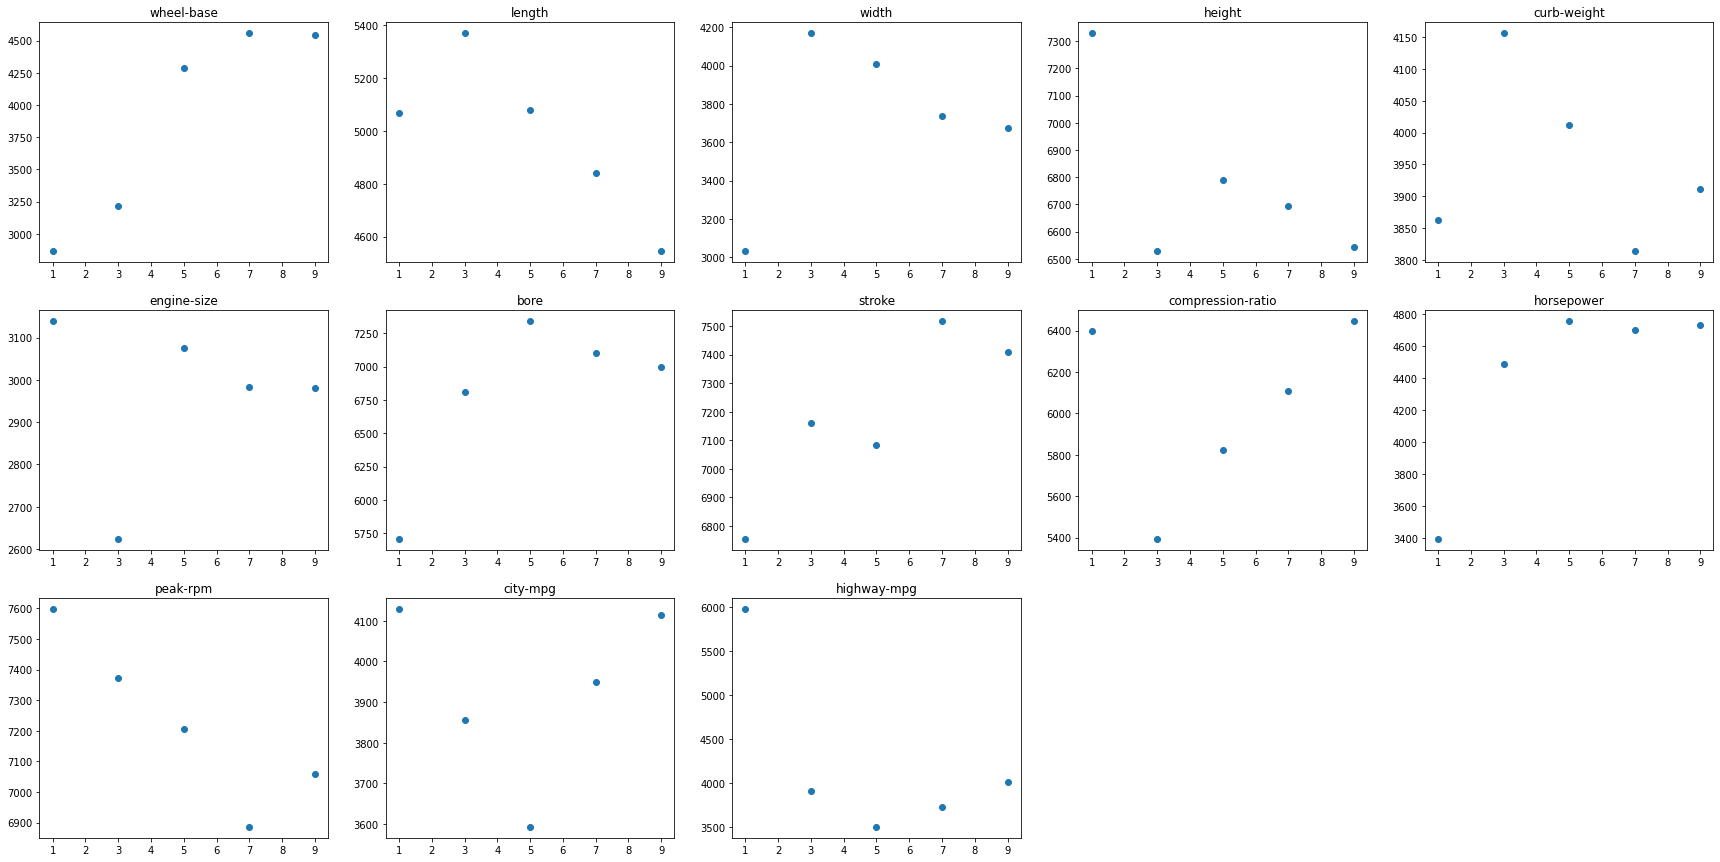

In [ ]:
fig = plt.figure(figsize =(30, 15))

for n, col in enumerate(rmse_df):
    # add a new subplot iteratively
    ax = plt.subplot(3, 5, n + 1)

    ax.scatter(rmse_df.index, rmse_df[col])
    ax.set_title(col)

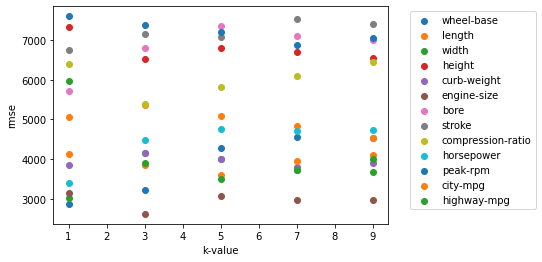

In [ ]:
for col in columns:
    plt.scatter(rmse_df.index, rmse_df[col])

plt.xlabel("k-value")
plt.ylabel("rmse")
plt.legend(columns, bbox_to_anchor = (1.05, 1))
plt.show()

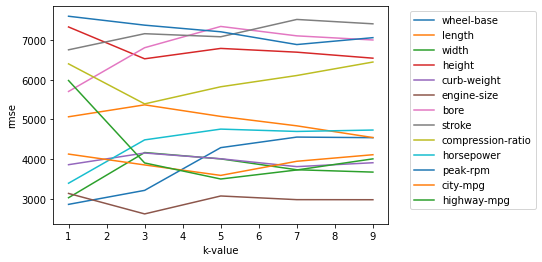

In [ ]:
for col in columns:
    plt.plot(rmse_df.index, rmse_df[col])

plt.xlabel("k-value")
plt.ylabel("rmse")
plt.legend(columns, bbox_to_anchor = (1.05, 1))
plt.show()

The best predictor using a univariate model is engine-size with k-value of 3.

In [ ]:
rmse_df[rmse_df['engine-size'].min() == rmse_df['engine-size']]

,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
3,3216.117747,5368.576392,4168.102358,6527.309706,4156.32162,2623.407714,6806.415332,7159.031492,5392.705973,4486.625165,7373.976378,3856.157443,3906.392752


## Multivariate Model
To improve the accuracy of our model we will now use additional relevant attributes or features to determine similarity when calculating closest neighbors.

In [ ]:
def knn_train_test(train_cols, target_col, df, k=5):
    np.random.seed(1)
    # randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # split the data - 75% into a training set and 25% into a test set
    total_rows = rand_df.shape[0]
    split_index = int(np.floor(total_rows * .75))
    train_df = rand_df.iloc[0:split_index]
    test_df = rand_df.iloc[split_index:]
    # fit the model on the training set
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    knn.fit(train_df[train_cols], train_df[target_col])
    # make predictions on the test set
    predictions = knn.predict(test_df[train_cols])
    # calculate the RMSE and return that value
    mse = mean_squared_error(test_df[target_col], predictions)
    rmse = math.sqrt(mse)
    return rmse

Using all of the columns and the default k-value resulted in a lower [Root Mean Square Error (RMSE)](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e) than any single column with any of our tested k-values.

Let's try using the best 2, 3, 4, & 5 features from the previous step to train and test a multivariate k-nearest neighbors model using the default k-value. First we will rank each of the features in order of best performing.

In [ ]:
# Compute average RMSE across different `k` values for each feature.
rmse_df.mean().sort_values()

engine-size          2960.041205
width                3723.582944
wheel-base           3894.128336
city-mpg             3927.942073
curb-weight          3950.959313
highway-mpg          4225.549700
horsepower           4414.712749
length               4979.832892
compression-ratio    6033.769647
height               6776.367782
bore                 6791.796006
stroke               7183.921323
peak-rpm             7224.969811
dtype: float64

In [ ]:
sorted_features = list(rmse_df.mean().sort_values().index)
sorted_features

['engine-size',
 'width',
 'wheel-base',
 'city-mpg',
 'curb-weight',
 'highway-mpg',
 'horsepower',
 'length',
 'compression-ratio',
 'height',
 'bore',
 'stroke',
 'peak-rpm']

In [ ]:
best2 = sorted_features[:2]
rmse = knn_train_test(train_cols=best2, target_col='price', df=cars_clean, k=5)
print(best2, rmse)

['engine-size', 'width'] 2612.9374837752334


In [ ]:
best3 = sorted_features[:3]
rmse = knn_train_test(train_cols=['curb-weight', 'highway-mpg', 'engine-size'], target_col='price', df=cars_clean, k=5)
print(best3, rmse)

['engine-size', 'width', 'wheel-base'] 2712.3444384777495


In [ ]:
best4 = sorted_features[:4]
rmse = knn_train_test(train_cols=['curb-weight', 'highway-mpg', 'engine-size', 'horsepower'], target_col='price', df=cars_clean, k=5)
print(best4, rmse)

['engine-size', 'width', 'wheel-base', 'city-mpg'] 2439.9092041930335


In [ ]:
best5 = sorted_features[:5]
rmse = knn_train_test(train_cols=['curb-weight', 'highway-mpg', 'engine-size', 'horsepower', 'city-mpg'], target_col='price', df=cars_clean, k=5)
print(best5, rmse)

['engine-size', 'width', 'wheel-base', 'city-mpg', 'curb-weight'] 2572.356902172959


Using the default k-value and the best 4 features produced the lowest RMSE and is therefore the best predictor that we have tested.

## Hyperparameter Tuning

When we vary the features that are used in the model, we're affecting the data that the model uses. On the other hand, varying the k value affects the behavior of the model independently of the actual data that's used when making predictions. In other words, we're impacting how the model performs without trying to change the data that's used.

Values that affect the behavior and performance of a model that are unrelated to the data that's used are referred to as hyperparameters. The process of finding the optimal hyperparameter value is known as hyperparameter optimization. A simple but common hyperparameter optimization technique is known as grid search, which involves:
* selecting a subset of the possible hyperparameter values,
training a model using each of these hyperparameter values,
* evaluating each model's performance,
* selecting the hyperparameter value that resulted in the lowest error value.

For the top 3 models in the last step, let's vary the hyperparameter value from 1 to 25 and plot the resulting RMSE values.

In [ ]:
k_values = [i for i in range(1,26)]
data = []

# loop through k-values
for k in k_values:
    rmses = []
    # loop through each set of columns
    for train_cols in [best2, best4, best5, sorted_features]:
        rmse = knn_train_test(train_cols, target_col='price', df=cars_clean, k=k)
        rmses.append(rmse)
    # append row of rmses to data
    data.append(rmses)

# create dataframe from data
best_rmse = pd.DataFrame(data, k_values, ['best2', 'best4', 'best5', 'all'])
best_rmse

,best2,best4,best5,all
1,2426.044024,2364.559321,2131.106971,2409.068891
2,2259.659556,2627.306174,2493.018916,2424.583395
3,2421.305249,2583.449270,2496.159249,2478.989111
4,2560.988463,2649.716662,2588.640862,2626.363943
5,2612.937484,2710.697874,2546.710588,2501.855184
6,2720.039343,2598.551075,2544.859755,2566.087636
7,2725.665215,2614.445361,2606.406502,2614.602030
8,2764.910470,2722.945475,2815.622969,2658.486916
9,2834.490186,2720.966665,2785.461021,2831.065885
10,2884.628829,2690.988494,2769.388064,2824.145531


For each column, see what k-value produced the lowest RMSE.

In [ ]:
best_rmse[best_rmse['best2'] == best_rmse['best2'].min()]['best2']

2    2259.659556
Name: best2, dtype: float64

In [ ]:
best_rmse[best_rmse['best4'] == best_rmse['best4'].min()]['best4']

1    2364.559321
Name: best4, dtype: float64

In [ ]:
best_rmse[best_rmse['best5'] == best_rmse['best5'].min()]['best5']

1    2131.106971
Name: best5, dtype: float64

In [ ]:
best_rmse[best_rmse['all'] == best_rmse['all'].min()]['all']

1    2409.068891
Name: all, dtype: float64

The optimal k-value was 1 or 2. Let's visualize this in a graph.

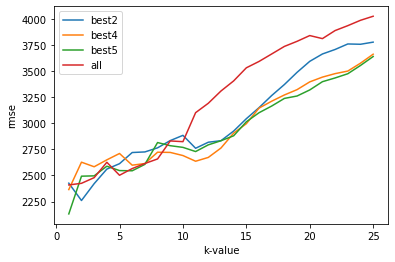

In [ ]:
for col in best_rmse:
    plt.plot(best_rmse.index, best_rmse[col])

plt.xlabel("k-value")
plt.ylabel("rmse")
plt.legend(best_rmse.columns)
plt.show()

In the univariate model, the RMSE values were somewhat evenly distributed across all the k-values. In the multivariate model lower k-values result in lower RMSEs.

Choosing a k-value of 1, would mean only using the characteristics of 1 car to predict the target price. Logically this seems like it would be unreliable. Estimating probablility based on a single observation might make the model more sensitive to noise & outliers. 

Some suggest using the square root of the umber of samples in the training dataset. http://theprofessionalspoint.blogspot.com/2019/02/how-to-choose-optimal-value-of-k-in-knn.html

In [ ]:
math.sqrt(150)

12.24744871391589

We will choose 2 as the optimal k-value for our model.

## Cross Validation
Instead of test/train validation, let's use a more robust technique called k-fold cross validation. 

For this validation technique we will
* Split the full dataset into k equal length partitions.
    * select k-1 partitions as the training set and
    * select the remaining partition as the test set
* Train the model on the training set.
* Use the trained model to predict labels on the test fold.
* Compute the test fold's error metric.
* Repeat all of the above steps k-1 times, until each partition has been used as the test set for an iteration.
* Calculate the mean of the k error values.

K-fold cross validation is better than train/test validation because the model isn't repeatedly biased towards a specific subset of the data. It also takes advantage of a larger proportion of the data during training while still rotating through different subsets of the data.

Instad of doing this by hand we will use the [sklearn module K-Folds cross-validator](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_score

#### A note on choosing k for k fold:  
Choosing the right k value when performing k-fold cross validation is more of an art and less of a science. A k value of 2 is really just holdout validation. On the other end, setting k equal to n (the number of observations in the data set) is known as leave-one-out cross validation, or LOOCV for short. Through lots of trial and error, data scientists have converged on 10 as the standard k value.

In [ ]:
def knn_train_test(train_cols, target_col, df, k_neighbors=5, k_folds=10):
    # instantiate the KFold class using the parameters to specify the k-fold cross-validation attributes we want
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=1)
    # instantiate the scikit-learn model class we want to fit
    model = KNeighborsRegressor(n_neighbors=k_neighbors, algorithm='brute')
    # use the cross_val_score() function to return the scoring metric we are interested in
    mses = cross_val_score(model, df[train_cols], df[target_col], scoring="neg_mean_squared_error", cv=kf)
    # get the root mean square errors from the mean square errors
    rmses = [np.sqrt(abs(mse)) for mse in mses]
    # calculate the average and standard deviation of the RMSEs
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    return [avg_rmse, std_rmse]

For our model, we will experiment with 5 and 10 folds.

In [ ]:
k_values = [5,6,7,8,9,10]
data_averages = []
data_stds = []

# loop through k-values
for k in k_values:
    averages = []
    stds = []
    # loop through each set of columns
    for train_cols in [best2, best4, best5, sorted_features]:
        avg_rmse, std_rmse = knn_train_test(train_cols, target_col='price', df=cars_clean, k_neighbors=2, k_folds=k)
        averages.append(avg_rmse)
        stds.append(std_rmse)
    # append row of rmses to data
    data_averages.append(averages)
    data_stds.append(stds)

# create dataframe from data
kfold_avgs = pd.DataFrame(data_averages, k_values, ['best2', 'best4', 'best5', 'all'])
kfold_stds = pd.DataFrame(data_stds, k_values, ['best2', 'best4', 'best5', 'all'])

kfold_avgs

,best2,best4,best5,all
5,2914.053517,2998.667275,2941.073817,2814.063505
6,2847.848827,2885.607263,2766.603960,2802.989042
7,2895.088750,2956.401654,2904.364879,2734.988191
8,2868.684518,2928.507490,2844.099719,2758.673531
9,2813.944827,2844.893059,2717.398917,2732.319764
10,2939.706095,2995.492897,2858.350745,2780.462362


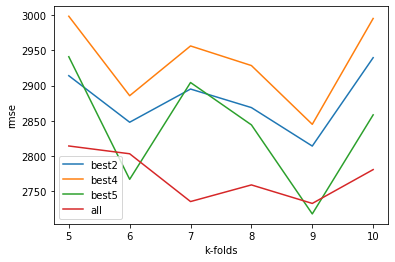

In [ ]:
for col in kfold_avgs:
    plt.plot(kfold_avgs.index, kfold_avgs[col])

plt.xlabel("k-folds")
plt.ylabel("rmse")
plt.legend(kfold_avgs.columns)
plt.show()

In [ ]:
kfold_avgs.mean()

best2    2879.887756
best4    2934.928273
best5    2838.648673
all      2770.582733
dtype: float64

Looking at RMSE it looks like using all features would be the best, followed by 5 or 2 features.

So far, we've been working under the assumption that a lower RMSE always means that a model is more accurate. This isn't the complete picture, unfortunately. A model has two sources of error, bias and variance.

Bias describes error that results in bad assumptions about the learning algorithm. For example, assuming that only one feature, like a car's weight, relates to a car's fuel efficiency will lead you to fit a simple, univariate regression model that will result in high bias. The error rate will be high since a car's fuel efficiency is affected by many other factors besides just its weight.

Variance describes error that occurs because of the variability of a model's predicted values. If we were given a dataset with 1000 features on each car and used every single feature to train an incredibly complicated multivariate regression model, we will have low bias but high variance. In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.

The standard deviation of the RMSE values can be a proxy for a model's variance while the average RMSE is a proxy for a model's bias. Bias and variance are the 2 observable sources of error in a model that we can indirectly control.

Let's take a look at the standard deviation of RMSEs.

In [ ]:
kfold_stds

,best2,best4,best5,all
5,637.725638,449.840746,527.127943,779.413013
6,540.242034,633.446184,646.902350,783.687763
7,519.179808,608.117077,583.349356,1013.415831
8,824.949839,718.972449,763.164155,1002.945736
9,593.890425,801.894500,818.487906,924.214871
10,804.869390,619.600576,703.808755,1015.224350


In [ ]:
kfold_stds.mean()

best2    653.476189
best4    638.645256
best5    673.806744
all      919.816927
dtype: float64

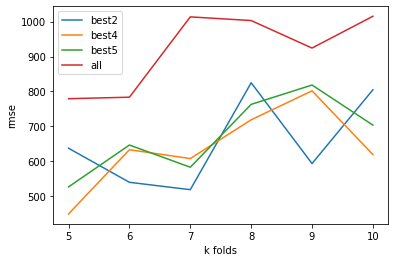

In [ ]:
for col in kfold_stds:
    plt.plot(kfold_stds.index, kfold_stds[col])

plt.xlabel("k folds")
plt.ylabel("rmse")
plt.legend(kfold_stds.columns)
plt.show()

If we take into account that we also want a model with low variance, using 4 or 2 features looks better.

For our final model we will go with using 2 features, engine-size & width. The default of 5 nearest neighbors, and 9 folds for cross validation.

In [ ]:
avg_rmse, std_rmse = knn_train_test(train_cols=['engine-size', 'width'], target_col='price', df=cars_clean, k_neighbors=5, k_folds=9)
avg_rmse, std_rmse

(3355.561461442259, 1191.0024418671687)

In [ ]:
cars_clean["price"].describe()

count      201.000000
mean     13207.129353
std       7947.066342
min       5118.000000
25%       7775.000000
50%      10295.000000
75%      16500.000000
max      45400.000000
Name: price, dtype: float64

In [ ]:
cars_clean["price"].max() - cars_clean["price"].min()

40282.0

In [ ]:
avg_rmse / (cars_clean["price"].max() - cars_clean["price"].min())

0.08330175913416064

Prices in the dataset range from $5,118$ to $45,400$ so we can say that our model predicts car prices with about 8% accuracy.

## Further investigation
If we choose to investigate further we may choose to do some [Exploratory Data Analysis (EDA)](https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15). The fact that we were getting optimal k values of 1 may mean that some of our fields are irrelevant and causing noise in our results.